In [21]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from pyDOE import lhs
import time
import math
import ot
from torchdiffeq import odeint
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)
from matplotlib import rcParams
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 24,
        }
import os
os.chdir('E:\Shi group research\ODE_trajectory\linear2D\ckpt')
print(os.getcwd())
plt.rcParams['font.family'] = 'Times New Roman'
plt.style.use('seaborn')
'''
loss_traj:
error two phase
loss_swd two phase
loss_pinn_traj one phase

shooting:
error
loss
x_gen
error_all

error:
error_all_phase1
error_all_phase2
x_gen_phase1 
x_gen_phase2
x_val
'''
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

E:\Shi group research\ODE_trajectory\linear2D\ckpt


# loss_trajectory

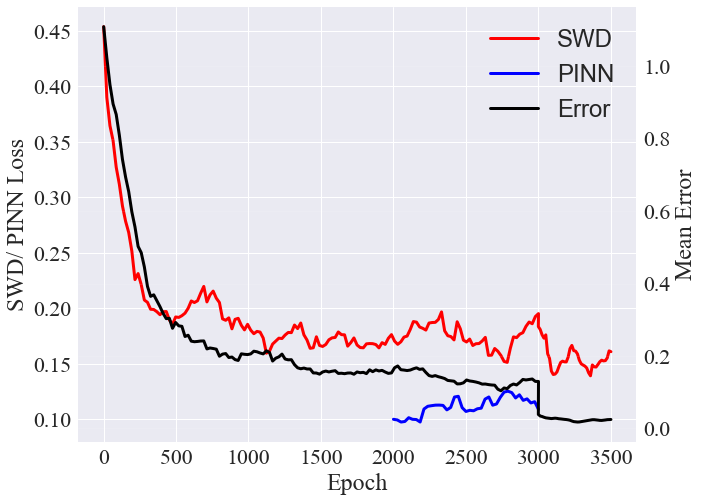

In [22]:
dict1 = loadmat('loss_traj.mat')
error_traj1 = np.asarray(dict1['error'])[0]
loss_traj1 = np.asarray(dict1['loss_swd'])[0]
loss_pinn = np.asarray(dict1['loss_pinn_traj'])[0]

def mean_list(values, stride=10, iters=1000):
    length = len(values)
    nums = length-stride
    mean_values = []
    std_vallues = []
    for k in range(nums):
        temp_list = values[k:k+stride]
        mean = np.mean(temp_list)
        std = np.std(temp_list)
        mean_values.append(mean)
        std_vallues.append(std)
    return np.asarray(mean_values), np.asarray(std_vallues)


loss_traj1,std_loss = mean_list(loss_traj1)
error_traj1,std_error = mean_list(error_traj1)
loss_pinn,std_pinn = mean_list(loss_pinn)
len1 = loss_traj1.shape[0]
dict2 = loadmat('shooting.mat')
error_traj2 = np.asarray(dict2['error'])[0]
loss_traj2 = np.asarray(dict2['loss'])[0]/6
loss_traj2,std_loss2 = mean_list(loss_traj2)
error_traj2,std_error2 = mean_list(error_traj2)
len2 = loss_traj2.shape[0]

error_traj1 = np.concatenate((error_traj1,error_traj2),axis = 0)
loss_traj1 = np.concatenate((loss_traj1,loss_traj2),axis = 0)
std_loss = np.concatenate((std_loss,std_loss2),axis = 0)
std_error = np.concatenate((std_error,std_error2),axis = 0)


loss_traj1_down = loss_traj1-std_loss
loss_traj1_up = loss_traj1+std_loss
error_traj1_down = error_traj1-std_error
error_traj1_up = error_traj1+std_error
loss_pinn_down = loss_pinn-std_pinn
loss_pinn_up = loss_pinn+std_pinn


iter = np.linspace(1,3001,len1)
iter_pinn = np.linspace(2000,3001,loss_pinn.shape[0])
iter_ode = np.linspace(3000,3501,len2)
iter = np.concatenate((iter,iter_ode),axis = 0)

fig, ax1 = plt.subplots(figsize=(10,8))
plt.xlabel('Epoch',font)
ax2 = ax1.twinx()
pic1 = ax1.plot(iter,loss_traj1,c ='r' ,label = 'SWD',linewidth = 3)
#ax1.fill_between(iter, loss_traj1_down, loss_traj1_up, color='C0', alpha=0.3)
#ax1.fill_between(iter_pinn, loss_pinn_down, loss_pinn_up,color ='C1', alpha=0.3)
#ax2.fill_between(iter, error_traj1_down, error_traj1_up, color='C2', alpha=0.3)
pic2 = ax1.plot(iter_pinn,loss_pinn,c ='b',label = 'PINN',linewidth = 3 )
pic3 = ax2.plot(iter,error_traj1,c ='k' ,label = 'Error',linewidth = 3 )
x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
ax1.tick_params(labelsize=22)

x1_label = ax2.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax2.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.grid(True,linestyle='-',alpha=0.1)
ax2.tick_params(labelsize=22)

pic = pic1+pic2+pic3
leg = [l.get_label() for l in pic]
ax1.set_ylabel('SWD/ PINN Loss',font)
ax2.set_ylabel('Mean Error',font)
plt.legend(pic,leg,fontsize=24)
plt.savefig('linear2d_loss.png')


# Scatter of X_gen

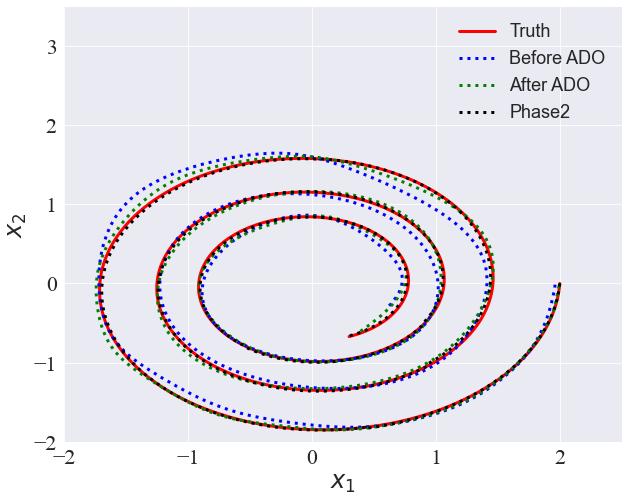

In [25]:
dict1 = loadmat('shooting.mat')
x_gen3 = np.asarray(dict1['x_gen'])
dict2 = loadmat('error.mat')
x_gen1 = np.asarray(dict2['x_gen_phase1'])
x_gen2 = np.asarray(dict2['x_gen_phase2'])
x_val = dict2['x_val']

fig,ax = plt.subplots(figsize=(10,8))
plt.plot(x_val[:,0],x_val[:,1],"r-",label = 'Truth',linewidth = 3)
plt.plot(x_gen1[:,0],x_gen1[:,1],"b:",label = 'Before ADO',linewidth = 3)
plt.plot(x_gen2[:,0],x_gen2[:,1],"g:",label = 'After ADO',linewidth = 3)
plt.plot(x_gen3[:,0],x_gen3[:,1],"k:",label = 'Phase2',linewidth = 3)
plt.legend(loc = 'upper right',fontsize=18)
plt.xlim(-2,2.5)
plt.ylim(-2,3.5)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.grid(True,linestyle='-',alpha=0.9)
ax.tick_params(labelsize=22)
plt.xlabel('$x_1$',font)
plt.ylabel('$x_2$',font)
plt.savefig('linear2d_trajectory.png')


# param

In [26]:
dict1 = loadmat('param_pinn.mat')
param = np.asarray(dict1['param1'])
error_param = np.asarray(dict1['error_param'])[0]
param = param.reshape((49,-1))
param_truth = np.array([-0.1,-2,2,-0.1])
error_1 = np.abs(param-param_truth)
iter = np.linspace(2001,3000,49)


dict2 = loadmat('param_ode.mat')
param_ode = np.asarray(dict2['param1'])
error_param_ode = np.asarray(dict2['error_param'])[0]
param_ode = param_ode.reshape((-1,4))
param_truth = np.array([-0.1,-2,2,-0.1])
error_2 = np.abs(param_ode-param_truth)

error = np.concatenate((error_1,error_2),axis =0)
error_pa = np.concatenate((error_param,error_param_ode),axis =0)
iter1 = np.linspace(2000,3000,error_1.shape[0])
iter2 = np.linspace(3000,3500,error_2.shape[0])
iter = np.concatenate((iter1,iter2),axis = 0)


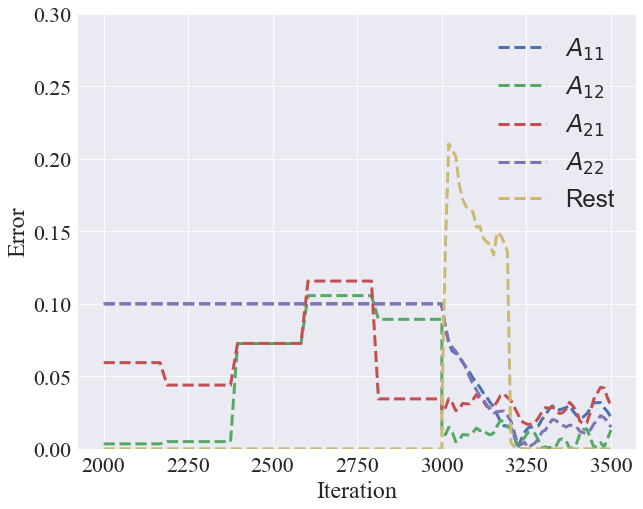

In [27]:
#plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 用来正常显示中文标签
fig,ax = plt.subplots(figsize=(10,8))
plt.plot(iter,error[:,0],'--',label = '$A_{11}$',linewidth = 3)
plt.plot(iter,error[:,1],'--',label = '$A_{12}$',linewidth = 3)
plt.plot(iter,error[:,2],'--',label = '$A_{21}$',linewidth = 3)
plt.plot(iter,error[:,3],'--',label = '$A_{22}$',linewidth = 3)
plt.plot(iter,error_pa,'--',label = 'Rest',linewidth = 3)
plt.legend(loc = 'upper right',fontsize=24)
plt.ylim(0.0,0.3)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.grid(True,linestyle='-',alpha=0.9)
ax.tick_params(labelsize=22)
plt.xlabel('Iteration',font)
plt.ylabel('Error',font)
plt.savefig('linear2d_param.png')

# Error time

In [28]:
import os
os.chdir('E:\Shi group research\ODE_trajectory\linear2D')
print(os.getcwd())
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from pyDOE import lhs
import time
import math
import ot
from torchdiffeq import odeint
from utils import linear_damped_SHO
from utils import cubic_damped_SHO
from utils import linear_3D
from utils import lorentz,HH
from tool import data_gen_real,cluster,compute_time_error
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
import os
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)
from matplotlib import rcParams
from model import MLP,Linear2D_system
import utils
x_init =  np.array([2.0,0.0])
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
x_init =  np.array([2.0,0.0])
eps = 0.02
full_bs = 50000
T = 10
utils.set_seed_everywhere(100)
n_cluster = 10
dim = 2
device = torch.device('cpu')
key = integrator_keywords
model ='Linear2D'
data_x,data_t = data_gen_real(full_bs,T,device,x_init,key,model)

data_all, data_init_all, time_all, t_start, time_length=\
            cluster(data=data_x.detach().cpu().numpy(),
                    n_cluster= n_cluster,
                    T=T,
                    data_t= data_t)
t_start = torch.cat(t_start,dim = 0)
t_start,index_time = torch.sort(t_start)
T1 = torch.tensor([0]).to(device)
T1[0] = T



ode_model = MLP(nh=500,nin = 1,nout=dim).to(device)

ode_model.load_state_dict(torch.load('results/ckpt_ADO.pth',map_location=torch.device('cpu')))
time_val = torch.linspace(0,T,50000)

pred_t_1,mean_error_1 = compute_time_error(ode_model,time_val,data_x,data_t,'NN')
print('Phase1 done')
ode_model = MLP(nh=500,nin = 1,nout=dim).to(device)
ode_model.load_state_dict(torch.load('results/ckpt_ADO_done.pth',map_location=torch.device('cpu')))
time_val = torch.linspace(0,T,50000)
pred_t_2,mean_error_2 = compute_time_error(ode_model,time_val,data_x,data_t,'NN')
print('ADO done')
model_param = Linear2D_system(device=device)
model_param.load_state_dict(torch.load('results/ckpt_shoot.pth',map_location=torch.device('cpu')))
time_val = torch.linspace(0,T,50000)
pred_t_3,mean_error_3 = compute_time_error(model=model_param,time_val=time_val,data_x=data_x,data_t=data_t,mode='ODE',data_init_all=data_init_all,t_start=t_start,T1=T1,index_time=index_time)
print('Phase2 done')




E:\Shi group research\ODE_trajectory\linear2D
Phase1 done
ADO done
Phase2 done


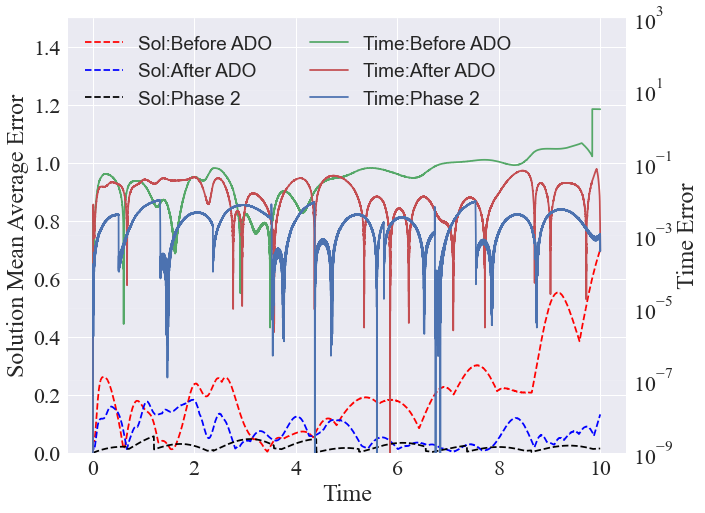

In [29]:

dict1 = loadmat('ckpt/shooting.mat')
error_all_phase3 = np.asarray(dict1['error_all'])
dict2 = loadmat('ckpt/error.mat')
error_all_phase1 = np.asarray(dict2['error_all_phase1'])
error_all_phase2 = np.asarray(dict2['error_all_phase2'])

error_p1 = np.linalg.norm(error_all_phase1,ord = 1,axis=1)
error_p2 = np.linalg.norm(error_all_phase2,ord = 1,axis=1)
error_p3 = np.linalg.norm(error_all_phase3,ord = 1,axis=1)
time = np.linspace(0,10,error_all_phase1.shape[0])

fig, ax1 = plt.subplots(figsize=(10,8))
plt.xlabel('Epoch',font)
# ax2 = ax1.twinx()
pic1 =ax1.plot(time,error_p1,'r--',label = 'Sol:Before ADO')
pic2 = ax1.plot(time,error_p2,'b--',label = 'Sol:After ADO')
pic3 =ax1.plot(time,error_p3,'k--',label = 'Sol:Phase 2')
ax1.set_ylabel('Solution Mean Average Error',font)
ax1.set_xlabel('Time',font)
ax1.set_ylim(0,1.5)
ax2 = ax1.twinx()

time1 = np.linspace(0,10,pred_t_1.shape[0])
# ax2 = ax1.twinx()
pic4 = ax2.plot(time1,mean_error_1,'C1',label = 'Time:Before ADO')
pic5 = ax2.plot(time1,mean_error_2,'C2',label = 'Time:After ADO')
pic6 = ax2.plot(time1,mean_error_3,'C6',label = 'Time:Phase 2')
ax2.set_ylabel('Time Error',font)
ax2.set_yscale('log')
ax2.set_ylim(1e-9,1e3)


x1_label = ax1.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax1.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
ax1.tick_params(labelsize=22)

x1_label = ax2.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax2.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.grid(True,linestyle='-',alpha=0.1)
ax2.tick_params(labelsize=22)

pic = pic1+pic2+pic3+pic4+pic5+pic6
leg = [l.get_label() for l in pic]
plt.legend(pic,leg,loc = 'upper left',ncol=2,fontsize=19)
plt.savefig('ckpt/linear2d_time.png')